In [64]:
from google.colab import files

uploaded = files.upload()  # Opens a file picker to upload files


In [65]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


In [66]:
train=pd.read_csv("train _competition.csv")
test=pd.read_csv("test_competition.csv")

In [67]:
train.isna().sum()

,0
id,0
Brand,9705
Material,8347
Size,6595
Compartments,0
Laptop Compartment,7444
Waterproof,7050
Style,7970
Color,9950
Weight Capacity (kg),138


In [68]:
train_numeric=train.select_dtypes(include=['int64','float64']).drop(columns=["Compartments","Price"])
test_numeric=test.select_dtypes(include=['int64','float64']).drop(columns=["Compartments"])

impute=KNNImputer()
train[train_numeric.columns]=impute.fit_transform(train_numeric)
test[test_numeric.columns]=impute.transform(test_numeric)

In [69]:
train.duplicated().sum()

0

In [70]:
train_=train.select_dtypes(include=['object'])
test_=test.select_dtypes(include=['object'])

Impute=SimpleImputer(strategy="most_frequent")
train[train_.columns]=Impute.fit_transform(train_)
test[test_.columns]=Impute.transform(test_)

In [71]:
train.duplicated().sum()

0

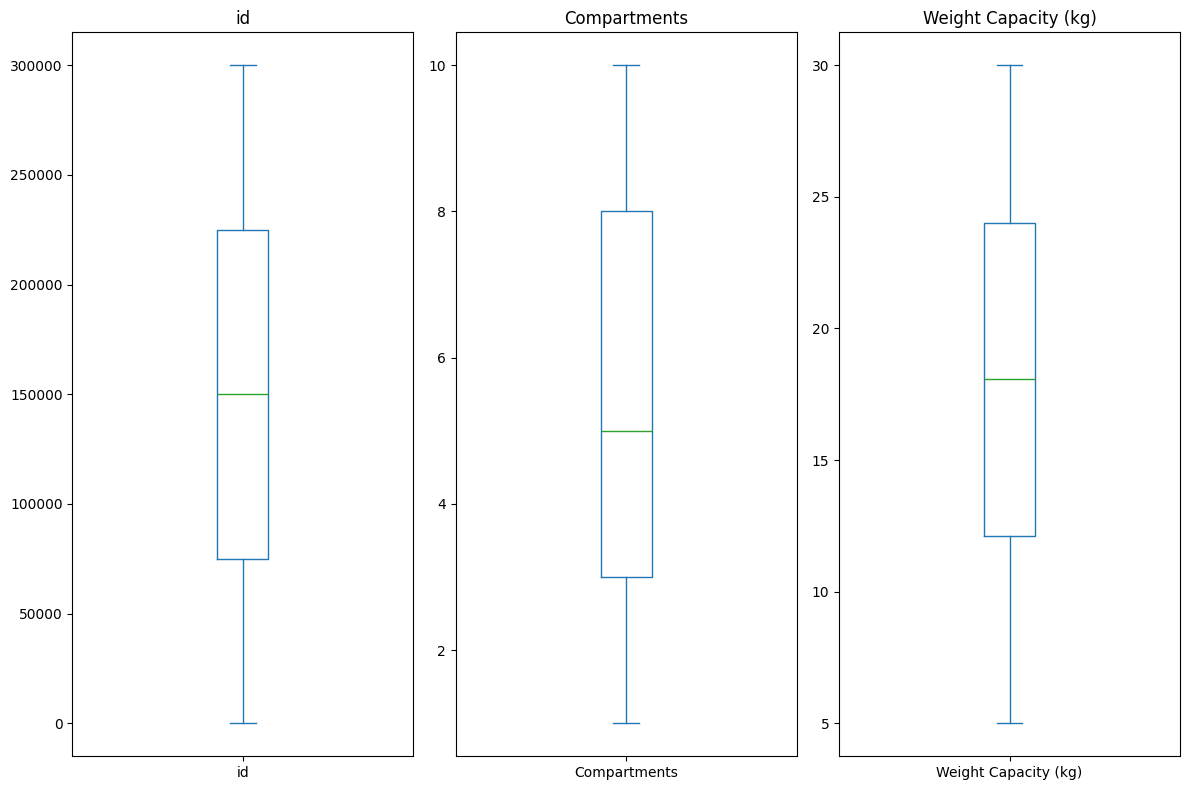

In [72]:

df = train.select_dtypes(include=['float64','int64']).drop(columns=['Price'])
plt.figure(figsize=(12, 8))

for idx, column in enumerate(df.columns,1):
    plt.subplot(1,len(df.columns), idx )
    train[column].plot(kind='box')
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

In [73]:
train["Waterproof"].replace({"Yes":1,"No":0},inplace=True)
test["Waterproof"].replace({"Yes":1,"No":0},inplace=True)
train["Laptop Compartment"].replace({"Yes":1,"No":0},inplace=True)
test["Laptop Compartment"].replace({"Yes":1,"No":0},inplace=True)


<ipython-input-73-8624d970f9a2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Waterproof"].replace({"Yes":1,"No":0},inplace=True)
<ipython-input-73-8624d970f9a2>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["Waterproof"].replace({"Yes":1,"No":0},inplace=True)
<ipython-input-73-86

In [74]:
train["Waterproof"].astype('int64')
test["Waterproof"].astype('int64')
train["Laptop Compartment"].astype('int64')
test["Laptop Compartment"].astype('int64')


,Laptop Compartment
0,0
1,0
2,0
3,1
4,1
...,...
199995,1
199996,0
199997,0
199998,1


In [75]:
report = []
threshold = 0.05

for column in train.drop(columns="Price").columns:
    result = ks_2samp(train[column], test[column])
    report.append({"column": column, "pvalue": result.pvalue, "drift_status": result.pvalue < threshold})

report_df = pd.DataFrame(report)
report_df

,column,pvalue,drift_status
0,id,0.000000,True
1,Brand,0.999989,False
2,Material,0.554328,False
3,Size,0.989222,False
4,Compartments,0.991316,False
5,Laptop Compartment,0.996052,False
6,Waterproof,1.000000,False
7,Style,0.898314,False
8,Color,0.793800,False
9,Weight Capacity (kg),0.306428,False


In [76]:
train.drop(columns="id",inplace=True)
test.drop(columns="id",inplace=True)

In [77]:

train.select_dtypes(include=["float64","int64"]).corr()

,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Price
Compartments,1.000000,-0.003252,-0.004778,0.002542,-0.000131
Laptop Compartment,-0.003252,1.000000,-0.027695,0.003615,-0.001321
Waterproof,-0.004778,-0.027695,1.000000,0.004551,-0.003984
Weight Capacity (kg),0.002542,0.003615,0.004551,1.000000,0.017998
Price,-0.000131,-0.001321,-0.003984,0.017998,1.000000


In [78]:
numeric_train = train.select_dtypes(include=['int64', 'float64'])

X = add_constant(numeric_train)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

               Variable        VIF
0                 const  17.604032
1          Compartments   1.000041
2    Laptop Compartment   1.000795
3            Waterproof   1.000830
4  Weight Capacity (kg)   1.000366
5                 Price   1.000343


In [79]:
numeric_test = test.select_dtypes(include=['int64', 'float64'])

X = add_constant(numeric_train)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

               Variable        VIF
0                 const  17.604032
1          Compartments   1.000041
2    Laptop Compartment   1.000795
3            Waterproof   1.000830
4  Weight Capacity (kg)   1.000366
5                 Price   1.000343


In [80]:
x=train.drop(columns="Price")

y=train["Price"]




In [81]:
x

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723
1,Jansport,Canvas,Small,10.0,1,1,Messenger,Green,27.078537
2,Under Armour,Leather,Small,2.0,1,0,Messenger,Red,16.643760
3,Nike,Nylon,Small,8.0,1,0,Messenger,Green,12.937220
4,Adidas,Canvas,Medium,1.0,1,1,Messenger,Green,17.749338
...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,0,0,Tote,Blue,12.730812
299996,Jansport,Leather,Large,6.0,0,1,Tote,Blue,26.633182
299997,Puma,Canvas,Large,9.0,1,1,Backpack,Pink,11.898250
299998,Adidas,Nylon,Small,1.0,0,1,Tote,Pink,6.175738


In [82]:
x["Compartments_Weight"] = x["Compartments"] * x["Weight Capacity (kg)"]
test["Compartments_Weight"] = test["Compartments"] * test["Weight Capacity (kg)"]


In [83]:
x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.2,random_state=42)

In [84]:
x_train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Compartments_Weight
254099,Nike,Leather,Medium,1.0,1,0,Backpack,Gray,27.294880,27.294880
53461,Puma,Polyester,Large,9.0,1,1,Messenger,Blue,8.574545,77.170905
247984,Adidas,Canvas,Medium,8.0,1,0,Messenger,Black,11.502436,92.019485
209067,Under Armour,Polyester,Medium,3.0,0,0,Backpack,Black,9.433317,28.299951
185997,Puma,Nylon,Small,8.0,0,1,Backpack,Black,8.971236,71.769885
...,...,...,...,...,...,...,...,...,...,...
119879,Jansport,Nylon,Large,7.0,0,0,Messenger,Gray,19.605766,137.240364
259178,Puma,Canvas,Large,10.0,1,1,Backpack,Pink,15.055192,150.551918
131932,Puma,Polyester,Large,10.0,0,1,Backpack,Black,14.794693,147.946928
146867,Adidas,Nylon,Large,5.0,0,0,Tote,Blue,21.067675,105.338374


In [85]:
x

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Compartments_Weight
0,Jansport,Leather,Medium,7.0,1,0,Tote,Black,11.611723,81.282060
1,Jansport,Canvas,Small,10.0,1,1,Messenger,Green,27.078537,270.785366
2,Under Armour,Leather,Small,2.0,1,0,Messenger,Red,16.643760,33.287520
3,Nike,Nylon,Small,8.0,1,0,Messenger,Green,12.937220,103.497762
4,Adidas,Canvas,Medium,1.0,1,1,Messenger,Green,17.749338,17.749338
...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,0,0,Tote,Blue,12.730812,114.577306
299996,Jansport,Leather,Large,6.0,0,1,Tote,Blue,26.633182,159.799093
299997,Puma,Canvas,Large,9.0,1,1,Backpack,Pink,11.898250,107.084247
299998,Adidas,Nylon,Small,1.0,0,1,Tote,Pink,6.175738,6.175738


In [86]:



numeric=x.select_dtypes(include=['int64','float64']).columns
category=x.select_dtypes(include=['object']).columns
numeric_features=list(numeric)
category_features=list(category)

In [87]:

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), category_features),
    ('scaling', StandardScaler(), numeric_features)
])


xgboost_reg = xgb.XGBRegressor(
    learning_rate=0.01,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8
)

rf_reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

sgd_reg = SGDRegressor(
    max_iter=1000,
    learning_rate='adaptive',
    alpha=0.01,
    penalty='l1',
    random_state=42
)


voting_regressor = VotingRegressor(estimators=[
    ('xgb', xgboost_reg),
    ('rf', rf_reg),
    ('sgd', sgd_reg),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('regression', voting_regressor)
])


pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Brand', 'Material', 'Size',
                                                   'Style', 'Color']),
                                                 ('scaling', StandardScaler(),
                                                  ['Compartments',
                                                   'Laptop Compartment',
                                                   'Waterproof',
                                                   'Weight Capacity (kg)',
                                                   'Compartments_Weight'])])),
                ('regression',
                 VotingRegressor(estimators=[('xgb',
                                              XGBRegressor(base_sc...
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=500,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...)),
                                             ('rf',
                                              RandomForestRegressor(max_depth=10,
                                                                    min_samples_leaf=3,
                                                                    min_samples_split=5,
                                                                    n_estimators=500,
                                                                    random_state=42)),
                                             ('sgd',
                                              SGDRegressor(alpha=0.01,
                                                           learning_rate='adaptive',
                                                           penalty='l1',
                                                           random_state=42))]))])

In [88]:
import pickle

with open('pipeline.pkl',"wb") as f:
  pickle.dump(pipeline,f)

In [97]:
y_pre_test=pipeline.predict(x_valid)
y_pre_train=pipeline.predict(x_train)
m1=mean_squared_error(y_train,y_pre_train)
m2=mean_squared_error(y_valid,y_pre_test)

In [98]:

print(f"train_error: {np.sqrt(m1)} , test_error: {np.sqrt(m2)}")

train_error: 38.860204028266295 , test_error: 38.91582146521159


In [99]:
predictions=pipeline.predict(test)

In [92]:
predictions

array([82.21562033, 82.16405025, 82.32368465, ..., 83.56035931,
       81.53527843, 80.70586921])

In [100]:
predictions_df = pd.DataFrame({
    'id': range(300000, 300000 + len(predictions)),
    'prediction': predictions
})

In [101]:

predictions_df

,id,prediction
0,300000,82.215620
1,300001,82.164050
2,300002,82.323685
3,300003,81.250044
4,300004,77.977668
...,...,...
199995,499995,79.736583
199996,499996,79.474972
199997,499997,83.560359
199998,499998,81.535278


In [102]:
predictions_df.to_csv('predictions.csv', index=False)

# New section

In [96]:
import os
print(os.getcwd())


/content
